# Colour - HDRI - Examples: Advanced Processing with an Input Device Transform

Through this example, some Canon EOS 5D Mark II *CR2* images will be merged together in order to create a single HDRI image. The Input Device Transform (IDT) will be computed by using the camera sensitivities.

The following steps will be taken:

- Retrieval of the camera sensitivities with [colour-datasets](https://github.com/colour-science/colour-datasets).
- Computation of the IDT at 6000K.
- Creation of an image stack using *CR2* images:
    - Reading of the *CR2* images *Exif* metadata using Phil Harvey's [ExifTool](http://www.sno.phy.queensu.ca/~phil/exiftool/).
    - Reading of the *CR2* images using [rawpy](https://github.com/neothemachine/rawpy).
    - Colour transformation using the computed IDT.
- Merging of the image stack into a HDRI image.
- Display of the final resulting HDRI image.

## Raw Files Filtering

In [1]:
import logging
import numpy as np
import os
import rawpy
import colour

# NOTE: Currently requires the latest develop branch.
import colour_datasets

from colour_hdri import (
    ROOT_RESOURCES_EXAMPLES,
    Image,
    ImageStack,
    filter_files,
    image_stack_to_HDRI,
    weighting_function_Debevec1997,
)
from colour_hdri.plotting import plot_HDRI_strip

logging.basicConfig(level=logging.INFO)

ROOT_RESOURCES = os.path.join(ROOT_RESOURCES_EXAMPLES, "frobisher_001")

colour.plotting.colour_style()

colour.utilities.describe_environment();

*                                                                             *
*   Interpreter :                                                             *
*       python : 3.10.8 (main, Oct 12 2022, 09:32:59) [Clang 14.0.0           *
*   (clang-1400.0.29.102)]                                                    *
*                                                                             *
*   colour-science.org :                                                      *
*       colour : 0.4.1                                                        *
*       colour-datasets : 0.2.0                                               *
*       colour-hdri : v0.1.8-156-g0bc7147                                     *
*                                                                             *
*   Runtime :                                                                 *
*       imageio : 2.22.1                                                      *
*       matplotlib : 3.6.1              

In [2]:
RAW_FILES = filter_files(ROOT_RESOURCES, ("CR2",))

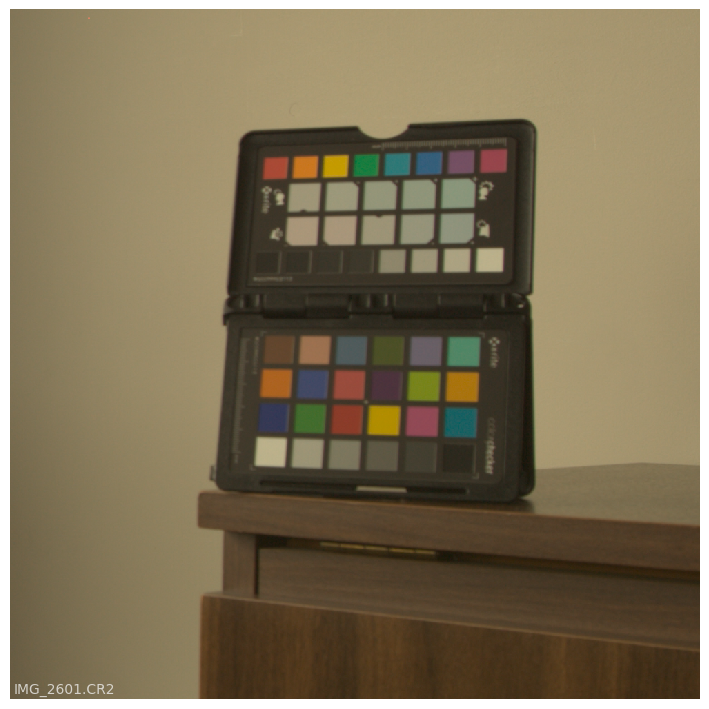

In [3]:
def read_raw_file_preview(path):
    raw = rawpy.imread(path).postprocess(
        gamma=(1, 1), no_auto_bright=True, output_bps=16
    )

    return colour.utilities.as_float_array(raw) / 65535


colour.plotting.plot_image(
    colour.cctf_encoding(
        read_raw_file_preview(RAW_FILES[-2])[1400:2400, 3200:4200, ...]
    ),
    text_kwargs={"text": os.path.basename(RAW_FILES[-2])},
);

## Camera Sensitivities

In [4]:
print(colour_datasets.datasets())

DATABASE_SENSITIVITIES = colour_datasets.load("6590768")

print(DATABASE_SENSITIVITIES.keys())

colour-science-datasets

Datasets : 22
Synced   : 1
URL      : https://zenodo.org/communities/colour-science-datasets/

Datasets
--------

[ ] 3269926 : Agfa IT8.7/2 Set - Marszalec (n.d.)
[ ] 3245883 : Camera Spectral Sensitivity Database - Jiang et al. (2013)
[ ] 3367463 : Constant Hue Loci Data - Hung and Berns (1995)
[ ] 3362536 : Constant Perceived-Hue Data - Ebner and Fairchild (1998)
[ ] 3270903 : Corresponding-Colour Datasets - Luo and Rhodes (1999)
[ ] 3269920 : Forest Colors - Jaaskelainen et al. (1994)
[ ] 4394536 : LUTCHI Colour Appearance Data - Luo and Rhodes (1997)
[ ] 3245875 : Labsphere SRS-99-020 - Labsphere (2019)
[ ] 3269924 : Lumber Spectra - Hiltunen (n.d.)
[ ] 4051012 : Measured Commercial LED Spectra - Brendel (2020)
[ ] 3269918 : Munsell Colors Glossy (All) (Spectrofotometer Measured) - Orava (n.d.)
[ ] 3269916 : Munsell Colors Glossy (Spectrofotometer Measured) - Haanpalo (n.d.)
[ ] 3269914 : Munsell Colors Matt (AOTF Measured) - Hauta-Kasari (n.d.)
[ ] 326991

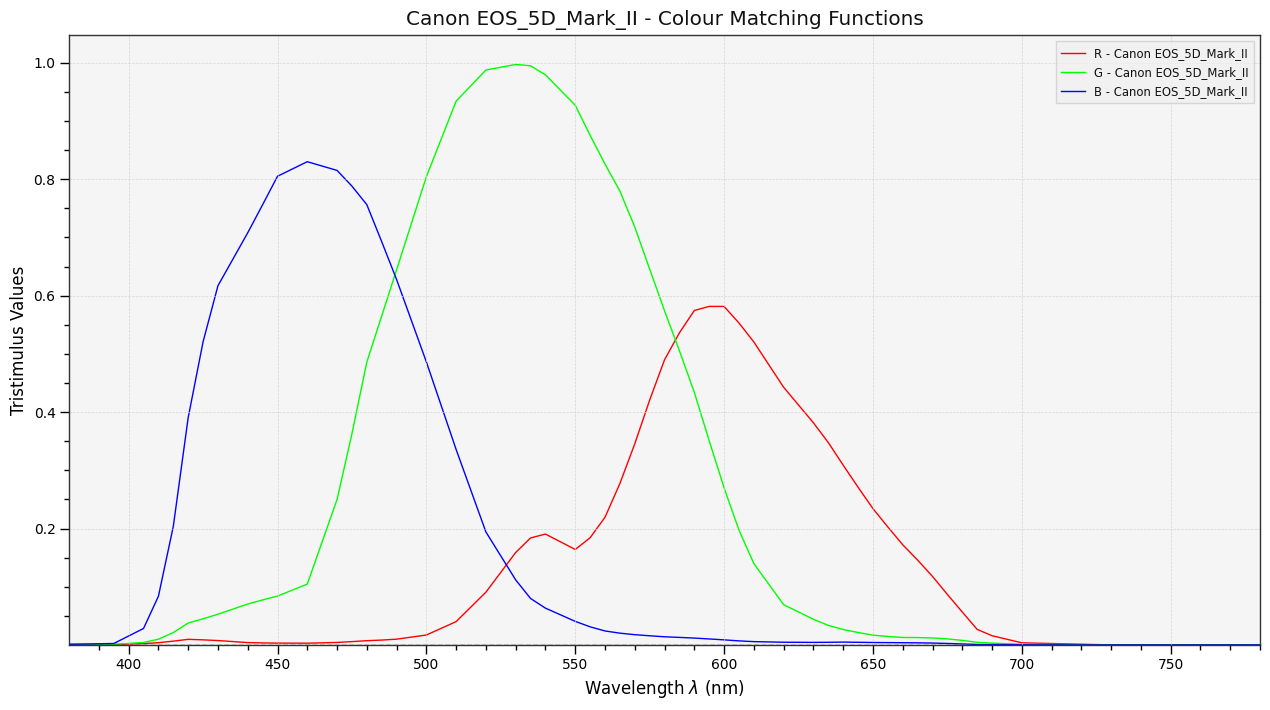

In [5]:
SENSITIVITIES = DATABASE_SENSITIVITIES["Canon EOS_5D_Mark_II"]

colour.plotting.plot_single_cmfs(SENSITIVITIES);

## Input Device Transform

In [6]:
CCT = 6000

SD_ILLUMINANT = colour.sd_CIE_illuminant_D_series(
    colour.temperature.CCT_to_xy_CIE_D(CCT * 1.4388 / 1.4380)
)

M_IDT, RGB_w = colour.matrix_idt(SENSITIVITIES, SD_ILLUMINANT)

logging.info(f'"IDT Matrix": {M_IDT}')
logging.info(f'"White Balance Multipliers": {RGB_w}')

INFO:root:"IDT Matrix": [[  8.22269843e-01   9.83542361e-04   1.59662187e-01]
 [  4.00697165e-02   1.12149525e+00  -1.68510676e-01]
 [  5.55051404e-02  -2.42973634e-01   1.17259529e+00]]
INFO:root:"White Balance Multipliers": [ 2.22481424  1.          1.51547049]


## HDRI Merge

In [7]:
def read_raw_file_processing(path):
    raw = rawpy.imread(path).postprocess(
        gamma=(1, 1),
        no_auto_bright=True,
        demosaic_algorithm=rawpy.DemosaicAlgorithm(11),
        highlight_mode=rawpy.HighlightMode(2),
        output_color=rawpy.ColorSpace(0),
        output_bps=16,
        user_wb=np.hstack([RGB_w, RGB_w[1]]).tolist(),
    )

    return colour.utilities.as_float_array(raw) / 65535


def merge_from_raw_files_using_rawpy(
    raw_files,
    output_directory,
    batch_size=5,
    weighting_function=weighting_function_Debevec1997,
):
    paths = []
    for raw_files in colour.utilities.batch(raw_files, batch_size):
        image_stack = ImageStack()
        for raw_file in raw_files:
            image = Image(raw_file)
            image.read_metadata()
            image.data = read_raw_file_processing(raw_file)
            image.data *= np.max(RGB_w)
            image.data = colour.RGB_to_RGB(
                colour.algebra.vector_dot(M_IDT, image.data),
                colour.models.RGB_COLOURSPACE_ACES2065_1,
                colour.models.RGB_COLOURSPACE_sRGB,
            )
            image_stack.append(image)

        path = os.path.join(
            output_directory,
            "{0}_{1}_MRFUR.{2}".format(
                os.path.splitext(os.path.basename(image_stack.path[0]))[0],
                batch_size,
                "exr",
            ),
        )
        paths.append(path)

        logging.info(f'Merging "{path}"...')
        logging.info(f'\tImage stack "F Number" (Exif): {image_stack.f_number}')
        logging.info(
            f'\tImage stack "Exposure Time" (Exif): {image_stack.exposure_time}'
        )
        logging.info(f'\tImage stack "ISO" (Exif): {image_stack.iso}')
        image = image_stack_to_HDRI(image_stack, weighting_function)

        logging.info(f'Writing "{path}"...')
        colour.write_image(image, path)

    return paths


PATHS = merge_from_raw_files_using_rawpy(RAW_FILES, ROOT_RESOURCES)

INFO:root:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2598.CR2" image metadata.
INFO:root:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2598.CR2' image EXIF data.
INFO:root:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2599.CR2" image metadata.
INFO:root:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2599.CR2' image EXIF data.
INFO:root:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2600.CR2" image metadata.
INFO:root:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_h

## HDRI image Display

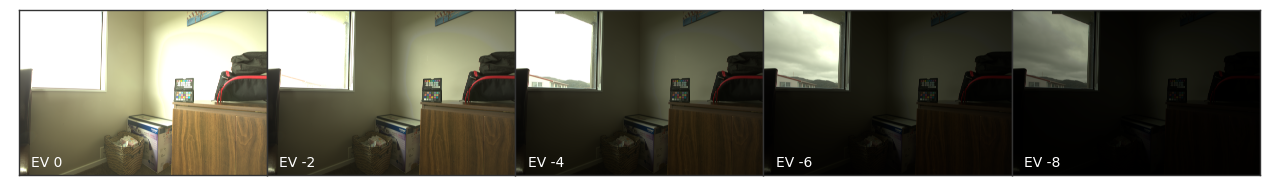

In [8]:
plot_HDRI_strip(colour.read_image(PATHS[0]));